## Example - Ptychography

In this example, we'll modify the BCDI setup so that instead of collecting and reconstructing one image, many diffraction patterns are collected over the sample area. Each sample image overlaps with the previous one, providing redundant information which aids the phase reconstruction and allows the imaging field to be scaled arbitrarily large - limited by stage movement, sample durability, and other physical factors rather than the available size of an optical lens. 

The process of collecting overlapping images can be done in several ways - the simplest is to step-and-repeat the collection of images over a pre-defined area, then do the post-processing offline. However, with large samples and/or small regions of interest, this may not be the most effective way to image. More advanced setups can be done in a "streaming" way, where the reconstructed real-space image is updated each step of the way and the process can be controlled with human feedback. To increase speed further, human feedback can be replaced with automated feature detection and search strategies. 

We'll start by looking at the simplest setup: offline processing.

In [1]:
import networkx as nx
import sys
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import namedtuple
from copy import deepcopy
from functools import reduce
from typing import Callable, Any
from itertools import accumulate

In [2]:
from systemflow.node import *
from systemflow.mutations import *
from systemflow.metrics import *
from systemflow.auxtypes import is_proportion
from systemflow.xrs import *

The basic setup for ptychography is the same as BCDI - a sample stage, far-field diffraction pattern sensor, and analysis computer. However, this time instead of taking and analyzing one image, we'll be taking a series of images collected from different sample positions.

The most basic strategy we can take is to acquire an image, step to the next position, and continue until the entire sample has been imaged. We'll define two execution graphs: acquiring an image, and the end-stage processing.

In [3]:
sample_stage_mutations = [PositionSample(),]
vc_sample = collect_parameters(sample_stage_mutations)

sample_stage = Component("Sample stage",
                    sample_stage_mutations,
                    {vc_sample.last_position: [0.0, 0.0],
                     vc_sample.position: [0.0, 0.0],
                     vc_sample.move_rate: 100,
                     vc_sample.settle_time: 1e-3,},
                     {})

<function PositionSample.<lambda> at 0x11b358790>


In [4]:
detector_mutations = [CollectImage(),]
vc_detector = collect_parameters(detector_mutations)

detector_host = Component("Image sensor",
                    detector_mutations,
                    parameters = {vc_detector.resolution: (2000, 2000),
                     vc_detector.bitdepth: 16,
                     vc_detector.readout: 1e-3,
                     vc_detector.pixelenergy: 1e-3,
                     vc_detector.sample_rate: 10e3,})

In [5]:
cpu_mutations = [StoreImage(),]
vc_storage = collect_parameters(cpu_mutations)

cpu_host = Component("CPU host",
                     cpu_mutations,
                     parameters={
                     vc_storage.storage_rate: 1e9,
                     vc_storage.stored_images: 0,
                     vc_storage.stored_data: 0,})

In [6]:
sampling_nodes = [sample_stage, detector_host, cpu_host]
sampling_links = [DefaultLink("Sample Stage -> Image sensor",
                              sample_stage.name,
                              detector_host.name),
                    DefaultLink("Image sensor -> CPU host",
                                detector_host.name,
                                cpu_host.name),]

sampling_metrics = [TotalLatency(),]

sampling_exg = ExecutionGraph(name="Sampling Process",
                              nodes=sampling_nodes,
                              links=sampling_links,
                              metrics=sampling_metrics)

In [7]:
# step through 1 iteration of collecting an image so we can examine the output
sampling_exg_2 = sampling_exg()

Position:  [0.0, 0.0]
Relevancy: 1.0


In [8]:
msg1 = sampling_exg_2.get_output_msg()

In [9]:
msg1.fields

{'relevancy (%)': 1.0,
 'readout latency (s)': 0.001,
 'image data (B)': np.float64(8000000.0),
 'position (mm,mm)': [0.0, 0.0],
 'movement latency (s)': np.float64(0.001),
 'stored data (B)': np.float64(8000000.0)}

In [10]:
msg1.properties

{'resolution (n,n)': (2000, 2000),
 'bitdepth (n)': 16,
 'sample rate (Hz)': 10000.0,
 'images (n)': 1,
 'stored images (n)': 1}

In [11]:
sampling_exg_2.nodes

In [12]:
sampling_exg_2.nodes[0].properties

{'storage latency (s)': np.float64(0.008)}

In [13]:
sampling_exg_2.nodes[0].parameters

{'disk storage rate (B/s)': 1000000000.0,
 'stored images (n)': 0,
 'stored data (B)': 0}

In [14]:
pdict = match_message_to_parameters(sampling_exg_2, vc_storage, cpu_host.name)

In [15]:
pdict

{'CPU host': {'stored data (B)': np.float64(8000000.0),
  'stored images (n)': 1}}

In [16]:
sampling_exg_2a = sampling_exg_2.with_updated_parameters(pdict)

In [17]:
sampling_exg_2a.nodes[0].parameters

{'disk storage rate (B/s)': 1000000000.0,
 'stored images (n)': 1,
 'stored data (B)': np.float64(8000000.0)}

In [18]:
sampling_exg_2a.nodes[0].parameters["stored images (n)"]

1

In [19]:
sampling_exg_3 = sampling_exg_2a()

Position:  [0.0, 0.0]
Relevancy: 1.0


In [20]:
sampling_exg_3.get_output_msg().properties

{'resolution (n,n)': (2000, 2000),
 'bitdepth (n)': 16,
 'sample rate (Hz)': 10000.0,
 'images (n)': 1,
 'stored images (n)': 2}

In [21]:
def serpentine_points(rect_limits, n_steps):
    """
    Generate a list of (x, y) points in a serpentine pattern over a rectangle.

    Parameters:
        rect_limits (tuple): (limit_x, limit_y) - dimensions of the rectangle.
        n_steps (tuple): (n_x, n_y) - number of steps in x and y directions.

    Returns:
        points (list): List of (x, y) tuples following the serpentine curve.
    """
    limit_x, limit_y = rect_limits
    n_x, n_y = n_steps

    x_vals = np.linspace(0, limit_x, n_x)
    y_vals = np.linspace(0, limit_y, n_y)

    points = []
    for j, y in enumerate(y_vals):
        if j % 2 == 0:
            # left to right
            for x in x_vals:
                points.append((x, y))
        else:
            # right to left
            for x in reversed(x_vals):
                points.append((x, y))
    return np.array(points)

In [22]:
pts = serpentine_points((20.0, 20.0), (20, 20))

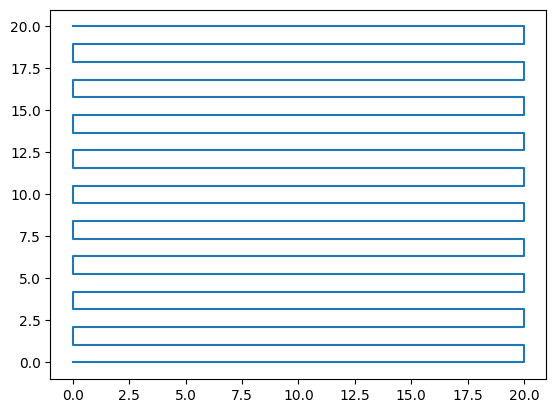

In [23]:
plt.plot(pts[:,0], pts[:,1])

In [24]:
pts.shape

(400, 2)

In [25]:
sampling_exg

In [26]:
sampling_exg.get_all_node_parameters()

{'Sample stage': {'last position (mm,mm)': [0.0, 0.0],
  'position (mm,mm)': [0.0, 0.0],
  'move rate (mm/s)': 100,
  'settle time (s)': 0.001},
 'Image sensor': {'resolution (n,n)': (2000, 2000),
  'bit depth (n)': 16,
  'readout latency (s)': 0.001,
  'pixel energy (J)': 0.001,
  'sample rate (Hz)': 10000.0},
 'CPU host': {'disk storage rate (B/s)': 1000000000.0,
  'stored images (n)': 0,
  'stored data (B)': 0}}

In [27]:
sampling_exg.get_output_msg()

In [28]:
sampling_exg_2.get_all_node_parameters()

{'CPU host': {'disk storage rate (B/s)': 1000000000.0,
  'stored images (n)': 0,
  'stored data (B)': 0},
 'Image sensor': {'resolution (n,n)': (2000, 2000),
  'bit depth (n)': 16,
  'readout latency (s)': 0.001,
  'pixel energy (J)': 0.001,
  'sample rate (Hz)': 10000.0},
 'Sample stage': {'last position (mm,mm)': [0.0, 0.0],
  'position (mm,mm)': [0.0, 0.0],
  'move rate (mm/s)': 100,
  'settle time (s)': 0.001}}

In [29]:
sampling_exg_2.get_output_msg()

Message(fields={'relevancy (%)': 1.0, 'readout latency (s)': 0.001, 'image data (B)': np.float64(8000000.0), 'position (mm,mm)': [0.0, 0.0], 'movement latency (s)': np.float64(0.001), 'stored data (B)': np.float64(8000000.0)}, properties={'resolution (n,n)': (2000, 2000), 'bitdepth (n)': 16, 'sample rate (Hz)': 10000.0, 'images (n)': 1, 'stored images (n)': 1})

In [30]:
sample_stage.name

'Sample stage'

In [31]:
vc_sample

VarCollection(
    position='position (mm,mm)',
    last_position='last position (mm,mm)',
    move_rate='move rate (mm/s)',
    settle_time='settle time (s)'
)

In [32]:
match_message_to_parameters(sampling_exg_2, vc_sample)

{'position (mm,mm)': [0.0, 0.0]}

In [33]:
sampling_exg_2.get_output_msg().fields

{'relevancy (%)': 1.0,
 'readout latency (s)': 0.001,
 'image data (B)': np.float64(8000000.0),
 'position (mm,mm)': [0.0, 0.0],
 'movement latency (s)': np.float64(0.001),
 'stored data (B)': np.float64(8000000.0)}

In [34]:
vc_sample.last_position

'last position (mm,mm)'

In [35]:
sampling_exg.name

'Sampling Process'

In [36]:
analysis_mutations = [InputMessage(), 
                      FlatFieldCorrection(),
                    MaskCorrection(),
                    PhaseReconstruction3D(),]
vc_analysis = collect_parameters(analysis_mutations)
analysis_host = Component("Offline analysis",
                          analysis_mutations,
                          {vc_analysis.op_latency: 1e-5,
                           vc_analysis.parallelism: 0.70,
                           vc_analysis.overlap: 0.40,
                           vc_analysis.mask_proportion: 0.05,
                           vc_analysis.kernel_size: (0.02, 0.02),
                           vc_analysis.iterations: 20,
                           vc_analysis.xy_images: (20, 20),
                           vc_analysis.input_message: sampling_exg_2.get_output_msg(),})


In [37]:
cpu_mutations = [FlatFieldCorrection(),
                MaskCorrection(),
                PhaseReconstruction3D(),]

vc_cpu = collect_parameters(cpu_mutations)

In [38]:
analysis_exg = ExecutionGraph("Offline reconstruction",
                              [analysis_host,],
                              links = [],
                              metrics = [])

In [39]:
sampling_exg_2.nodes[0].name

'CPU host'

In [40]:
sampling_exg_2.get_output_msg().properties

{'resolution (n,n)': (2000, 2000),
 'bitdepth (n)': 16,
 'sample rate (Hz)': 10000.0,
 'images (n)': 1,
 'stored images (n)': 1}

In [41]:
match_message_to_parameters(sampling_exg_2, collect_parameters(sampling_exg.get_mutations()), "CPU host")

{'CPU host': {'position (mm,mm)': [0.0, 0.0],
  'resolution (n,n)': (2000, 2000),
  'readout latency (s)': 0.001,
  'sample rate (Hz)': 10000.0,
  'stored data (B)': np.float64(8000000.0),
  'stored images (n)': 1}}

In [42]:
sampling_exg_2.get_node("Sample stage")

In [43]:
sampling_exg_2.list_nodes()

['CPU host', 'Image sensor', 'Sample stage']

In [44]:
sampling_exg_2.get_node("Sample stage")

In [45]:
collect_parameters(sampling_exg_2.get_node("CPU host").mutations)

VarCollection(
    stored_data='stored data (B)',
    stored_images='stored images (n)',
    storage_rate='disk storage rate (B/s)'
)

We've now setup the components necessary to collect an image which will become part of the reconstruction. However, this collection becomes a multi-step process which we must model. We do this by incorporating a new element, a System which controls the flow of different execution graphs:

In [46]:
class OfflinePtychographySystem(System):
    def __init__(self, sample_limits: tuple, n_steps: tuple, sampling_exg: ExecutionGraph, analysis_exg: ExecutionGraph, cpu_hostname="CPU host"):
        super().__init__("Offline Ptychography", 
                         {sampling_exg.name: sampling_exg,
                          analysis_exg.name: analysis_exg,},
                         )
        
        #copy the execution graphs
        self.sampling_exg = deepcopy(sampling_exg)
        self.analysis_exg = deepcopy(analysis_exg)
        self.cpu_hostname = cpu_hostname
        #what are the limits on the sample size
        self.sample_limits = sample_limits
        #how many steps are we taking across it?
        self.n_steps = n_steps

    def step(self, execution_history, new_position):
        previous_graph = execution_history[-1]
        vc_storage = collect_parameters(self.sampling_exg.get_node(self.cpu_hostname).mutations)
        vc_sample = collect_parameters(self.sampling_exg.get_mutations())
        #find out where the previous sample position was
        previous_position = previous_graph.get_output_msg().fields[vc_sample.position]
        #find how many images & how much data were stored in the graph its last call
        new_cpu_params = match_message_to_parameters(previous_graph, vc_storage, self.cpu_hostname)
        new_sample_params = {"Sample stage": {vc_sample.last_position: previous_position,
                                                    vc_sample.position: new_position,}}
        
        new_params = new_cpu_params | new_sample_params
        
        new_graph = previous_graph.with_updated_parameters(new_params)()
        return new_graph

    def flow_control(self):
        execution_history = []
        vc_analysis = collect_parameters(self.analysis_exg.get_mutations())
        #initialize the first step
        execution_history.append(self.sampling_exg())
        #generate the points we're moving over
        sample_points = serpentine_points(self.sample_limits, self.n_steps)

        #collect and store the diffraction imaging data
        for point in sample_points:
            new_graph = self.step(execution_history, point)
            execution_history.append(new_graph)

        #then run the reconstruction
        #find the number of stored images
        final_msg = execution_history[-1].get_output_msg()
        analysis_graph = self.analysis_exg.with_updated_parameters(
            {self.analysis_exg.nodes[0].name: {vc_analysis.input_message: final_msg,
                                            vc_analysis.xy_images: self.n_steps}})
        
        execution_history.append(analysis_graph())

        return execution_history


In [47]:
optych = OfflinePtychographySystem((20.0, 20.0), (20, 20), sampling_exg, analysis_exg)

In [48]:
len(optych.execution_history)

0

In [49]:
optych_2 = optych()

Position:  [0.0, 0.0]
Relevancy: 1.0
Position:  [0. 0.]
Relevancy: 1.0
Position:  [1.05263158 0.        ]
Relevancy: 1.0
Position:  [2.10526316 0.        ]
Relevancy: 1.0
Position:  [3.15789474 0.        ]
Relevancy: 1.0
Position:  [4.21052632 0.        ]
Relevancy: 1.0
Position:  [5.26315789 0.        ]
Relevancy: 1.0
Position:  [6.31578947 0.        ]
Relevancy: 1.0
Position:  [7.36842105 0.        ]
Relevancy: 1.0
Position:  [8.42105263 0.        ]
Relevancy: 1.0
Position:  [9.47368421 0.        ]
Relevancy: 1.0
Position:  [10.52631579  0.        ]
Relevancy: 1.0
Position:  [11.57894737  0.        ]
Relevancy: 1.0
Position:  [12.63157895  0.        ]
Relevancy: 1.0
Position:  [13.68421053  0.        ]
Relevancy: 1.0
Position:  [14.73684211  0.        ]
Relevancy: 1.0
Position:  [15.78947368  0.        ]
Relevancy: 1.0
Position:  [16.84210526  0.        ]
Relevancy: 1.0
Position:  [17.89473684  0.        ]
Relevancy: 1.0
Position:  [18.94736842  0.        ]
Relevancy: 1.0
Position:  

In [50]:
posn = np.array([eg.get_output_msg().fields["position (mm,mm)"] for eg in optych_2.execution_history])

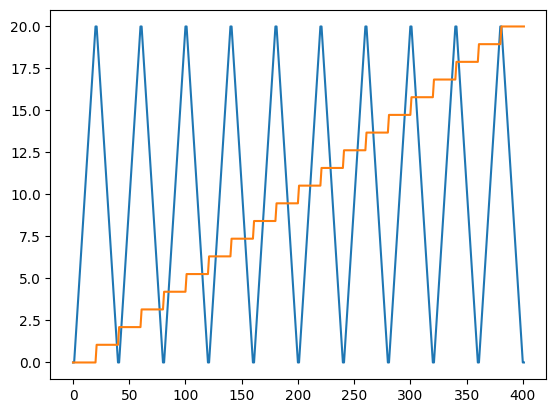

In [51]:
plt.plot(posn)

In [52]:
rel = np.array([eg.get_output_msg().fields["relevancy (%)"] for eg in optych_2.execution_history])

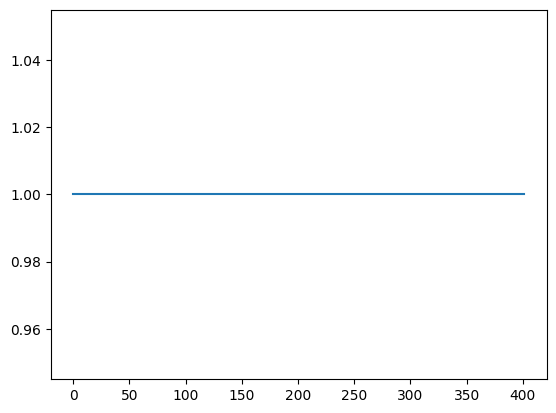

In [53]:
plt.plot(rel)

In [54]:
len(optych_2.execution_history)

402

In [55]:
len(optych.execution_history)

0

In [56]:
final_msg = optych_2.execution_history[-1].get_output_msg()

In [57]:
final_msg

Message(fields={'relevancy (%)': 1.0, 'readout latency (s)': 0.001, 'image data (B)': np.float64(8000000.0), 'position (mm,mm)': array([ 0., 20.]), 'movement latency (s)': np.float64(0.011526315789473683), 'stored data (B)': np.float64(3208000000.0), 'flatfield latency (s)': np.float64(0.0009563524997900376), 'masking corrections (B)': np.float64(400000.0), 'masking latency (s)': np.float64(0.0035607787827508933), 'reconstruction (B)': 64731679.36000001, 'phase data (B)': 25600000000}, properties={'resolution (n,n)': (2000, 2000), 'bitdepth (n)': 16, 'sample rate (Hz)': 10000.0, 'images (n)': 1, 'stored images (n)': 401, 'phase reconstruction (n,n)': (2011.4, 2011.4), 'phase reconstruction latency (s)': np.float64(0.02605099894164507)})

In [58]:
analysis_host.parameters[vc_analysis.overlap]

0.4

In [59]:
def centroid_relevancy(n_centroids: int, proportion: float, rect_limits: tuple):
    limit_x, limit_y = rect_limits
    rect_area = limit_x * limit_y
    roi_area = rect_area * proportion
    radius = np.sqrt(roi_area / (n_centroids * np.pi))

    centroids = np.column_stack((
        np.random.uniform(0, limit_x, n_centroids),
        np.random.uniform(0, limit_y, n_centroids)
    ))

    def relevancy_fn(coord):
        coord = np.asarray(coord)
        for c in centroids:
            if np.linalg.norm(coord - c) <= radius:
                return 1.0
        return 0.0

    return relevancy_fn

In [60]:
rel_f1 = centroid_relevancy(5, 0.10, (20.0, 20.0))

In [61]:
x = np.linspace(0, 20, 101)
y = np.linspace(0, 20, 101)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_points = np.column_stack([mesh_x.ravel(), mesh_y.ravel()])

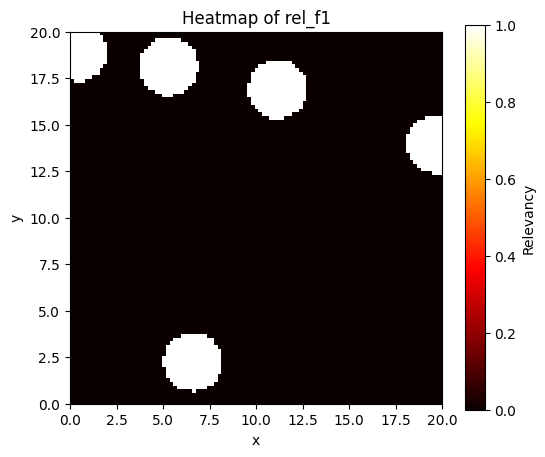

In [62]:
# Evaluate rel_f1 on the mesh grid
z = np.array([rel_f1(pt) for pt in mesh_points]).reshape(mesh_x.shape)

plt.figure(figsize=(6, 5))
plt.imshow(z, extent=(0, 20, 0, 20), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Relevancy')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of rel_f1')
plt.show()

In [69]:
centroid_sample_mutations = [PositionSample(relevancy_f=rel_f1),]
vc_centroid = collect_parameters(centroid_sample_mutations)

centroid_sample = Component("Sample stage",
                    centroid_sample_mutations,
                    {vc_centroid.last_position: [0.0, 0.0],
                     vc_centroid.position: [0.0, 0.0],
                     vc_centroid.move_rate: 100,
                     vc_centroid.settle_time: 1e-3,},
                     {})

<function centroid_relevancy.<locals>.relevancy_fn at 0x11cd05360>


In [70]:
sampling_nodes = [centroid_sample, detector_host, cpu_host]
sampling_links = [DefaultLink("Sample Stage -> Image sensor",
                              centroid_sample.name,
                              detector_host.name),
                    DefaultLink("Image sensor -> CPU host",
                                detector_host.name,
                                cpu_host.name),]

sampling_metrics = [TotalLatency(),]

sampling_exg = ExecutionGraph(name="Sampling Process",
                              nodes=sampling_nodes,
                              links=sampling_links,
                              metrics=sampling_metrics)

In [71]:
sampling_exg.get_node("Sample stage").mutations[0].relevancy_f

<function __main__.centroid_relevancy.<locals>.relevancy_fn(coord)>

In [72]:
centroid_optych = OfflinePtychographySystem((20.0, 20.0), (20, 20), sampling_exg, analysis_exg)

In [73]:
centroid_optych2 = centroid_optych()

Position:  [0.0, 0.0]
Relevancy: 0.0
Position:  [0. 0.]
Relevancy: 0.0
Position:  [1.05263158 0.        ]
Relevancy: 0.0
Position:  [2.10526316 0.        ]
Relevancy: 0.0
Position:  [3.15789474 0.        ]
Relevancy: 0.0
Position:  [4.21052632 0.        ]
Relevancy: 0.0
Position:  [5.26315789 0.        ]
Relevancy: 0.0
Position:  [6.31578947 0.        ]
Relevancy: 0.0
Position:  [7.36842105 0.        ]
Relevancy: 0.0
Position:  [8.42105263 0.        ]
Relevancy: 0.0
Position:  [9.47368421 0.        ]
Relevancy: 0.0
Position:  [10.52631579  0.        ]
Relevancy: 0.0
Position:  [11.57894737  0.        ]
Relevancy: 0.0
Position:  [12.63157895  0.        ]
Relevancy: 0.0
Position:  [13.68421053  0.        ]
Relevancy: 0.0
Position:  [14.73684211  0.        ]
Relevancy: 0.0
Position:  [15.78947368  0.        ]
Relevancy: 0.0
Position:  [16.84210526  0.        ]
Relevancy: 0.0
Position:  [17.89473684  0.        ]
Relevancy: 0.0
Position:  [18.94736842  0.        ]
Relevancy: 0.0
Position:  

In [74]:
len(centroid_optych.execution_history)

0

In [75]:
len(centroid_optych2.execution_history)

402

In [76]:
om = [eg.get_output_msg() for eg in centroid_optych2.execution_history]

In [77]:
len(om)

402

In [78]:
om[1]

Message(fields={'relevancy (%)': 0.0, 'readout latency (s)': 0.001, 'image data (B)': np.float64(8000000.0), 'position (mm,mm)': array([0., 0.]), 'movement latency (s)': np.float64(0.001), 'stored data (B)': np.float64(16000000.0)}, properties={'resolution (n,n)': (2000, 2000), 'bitdepth (n)': 16, 'sample rate (Hz)': 10000.0, 'images (n)': 1, 'stored images (n)': 2})

In [79]:
posn = np.array([eg.get_output_msg().fields["position (mm,mm)"] for eg in centroid_optych2.execution_history])

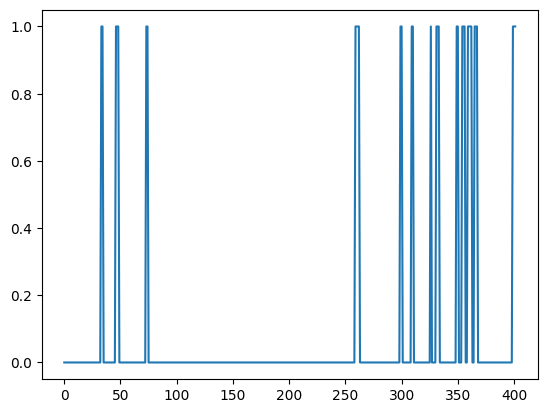

In [80]:
plt.plot([rel_f1(p) for p in posn])

In [81]:
relevancy = [eg.get_output_msg().fields["relevancy (%)"] for eg in centroid_optych2.execution_history]

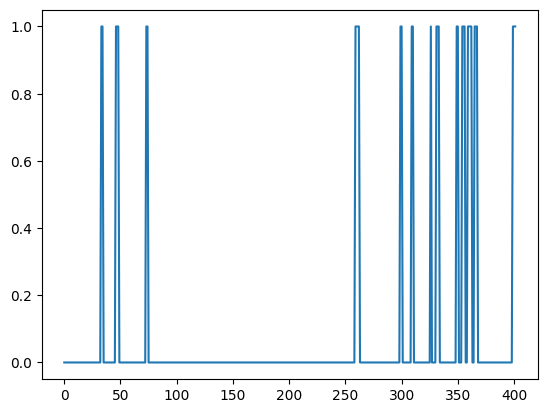

In [82]:
plt.plot(relevancy)

In [83]:
len(posn)

402

In [84]:
posn[50]

array([9.47368421, 2.10526316])

In [85]:
posn.shape

(402, 2)

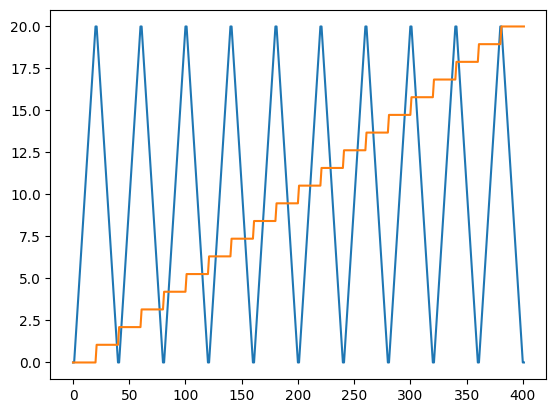

In [86]:
plt.plot(posn)

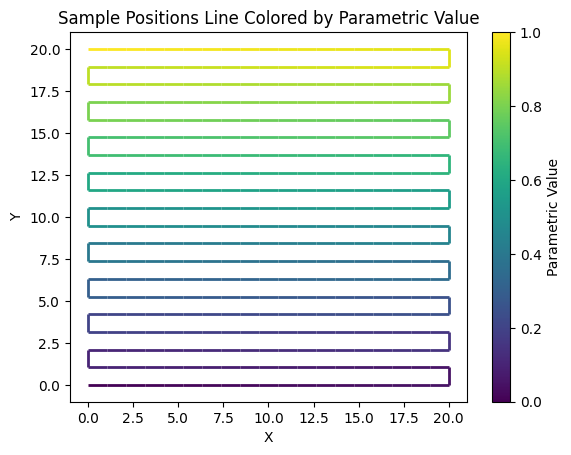

In [87]:
from matplotlib.collections import LineCollection

# Create segments between consecutive points
segments = np.array([posn[:-1], posn[1:]]).transpose(1, 0, 2)

# Parametric color: linear from 0 to 1
param = np.linspace(0, 1, len(segments))

lc = LineCollection(segments, cmap='viridis', array=param, linewidth=2)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
plt.colorbar(lc, ax=ax, label='Parametric Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sample Positions Line Colored by Parametric Value')
plt.show()